# Images of Outflows and their Predicted Sources

## Author: Pawel Janas

### Date: August 2022

This notebook is dedicated to showing each outflow source as was seen in a continuum subtracted image alongside a three-colour image of the outflow. Previous notebook titled `Outflow_Examine.ipynb` produced a master plot showcasing all outflows and predicted sources along with multi-pane images of certain outflows. This notebook will produce a definitive list of images dedicated to each outflow.

In [1]:
# use the entire screen width for the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
# make interactive plots
%matplotlib notebook

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, BboxPatch, TransformedBbox, \
BboxConnector
import pandas as pd
import glob # for filepath handling
import sys
#
import warnings
warnings.filterwarnings('ignore')
#
# Astropy:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import LinearStretch, LogStretch, ZScaleInterval, \
    MinMaxInterval, simple_norm
import reproject as rpj # needed for reproject module

sys.path.append('../code')
from reproject_combine import reproject, make_rgb
from continuum_sub import ContinuumSubtract
import outflow_lookup as ol

Firstly we will setup the path to the excel file to get data on each source. A dictionary object is created using the `pandas` module.

In [4]:
path_to_file = '/mnt/c/Users/pjjan/OneDrive - Maynooth University/DIAS/outflow_sources_NGC3324.xlsx' # Set file path of the excel file
dict_ = ol.get_dictionary(path_to_file)

In [5]:
def sort_fnames(file_names):
    """ Function for sorting string lists of file names. Follows JWST naming conventions for naming .fits files."""
    # First get list of integers
    int_ind = []
    for f in files:
        num = f[-14:-10]

        if num[0] == 'f': # Accounts for MIRI f1130 band and up
            num = int(num[1:])
        else:
            pass

        int_ind.append(int(num))
    
    # Now sort the list of int returning indices that would sort the array
    sort_indices = np.argsort(int_ind)
    file_arr = np.array(file_names)
    sorted_fnames = file_arr[sort_indices] # re-arrange fnames
    
    return sorted_fnames # returns array of sorted fnames

In [6]:
# Get image directory and get files for imaging and plot generation
img_dir = '/mnt/d/st_images/Carina_level3/'
files = glob.glob(img_dir+'*')[3:] # Gets all JWST images including MIRI, excluding folders
files = sort_fnames(files) # sort them in ascending wavelength number
print('Files found:')
for f in files:
    print(f)

Files found:
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f090w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f187n_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f200w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f335m_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_clear-f444w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o001_t017_nircam_f444w-f470n_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o002_t017_miri_f770w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o002_t017_miri_f1130w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o002_t017_miri_f1280w_i2d.fits
/mnt/d/st_images/Carina_level3/jw02731-o002_t017_miri_f1800w_i2d.fits


In [7]:
# Getting full subtracted image
c = ContinuumSubtract(files[5], files[4])
reproj_c = c.reproject_continuum()
scale_factor = 0.9756262810503796 # got previously from continuum sub notebook
full_subc = c.continuum_sub(reproj_c, scale_factor)

In [9]:
with fits.open(files[5]) as hdu:
    tar_header = hdu[1].header
    tar_data = hdu[1].data

target_wcs = WCS(tar_header)

In [10]:
# Reproject all image files onto target image (F444W-F470N)
reproj = reproject(files, target_wcs, tar_data)

# source-1 (PJ001)

In [20]:
focus = 'PJ001' # set desired focus
coords = ol.get_coordinates(path_to_file, focus) # Get coordinates of the source from the excel file
pixel_x, pixel_y = target_wcs.world_to_pixel(coords) # get pixel coordinates of the outflow
pixel_x, pixel_y = int(pixel_x), int(pixel_y)
region = ol.pixel_region(pixel_x, pixel_y, custom_bounds=(200,200,300,300))

# Crop images onto desired region
cropped = ol.crop_images(reproj, region)
c_crop = ol.crop_images([full_subc], region)[0] # crop the continuum image

In [37]:
# RGB image, choosing MIRI F1800W as red band
r = cropped[-1]
g = cropped[5]
b = cropped[2]
rgb_list = [b, g, r]
rgb = make_rgb(rgb_list, stretch=35, Q=0, minimum=[200, 0, 0])

<IPython.core.display.Javascript object>


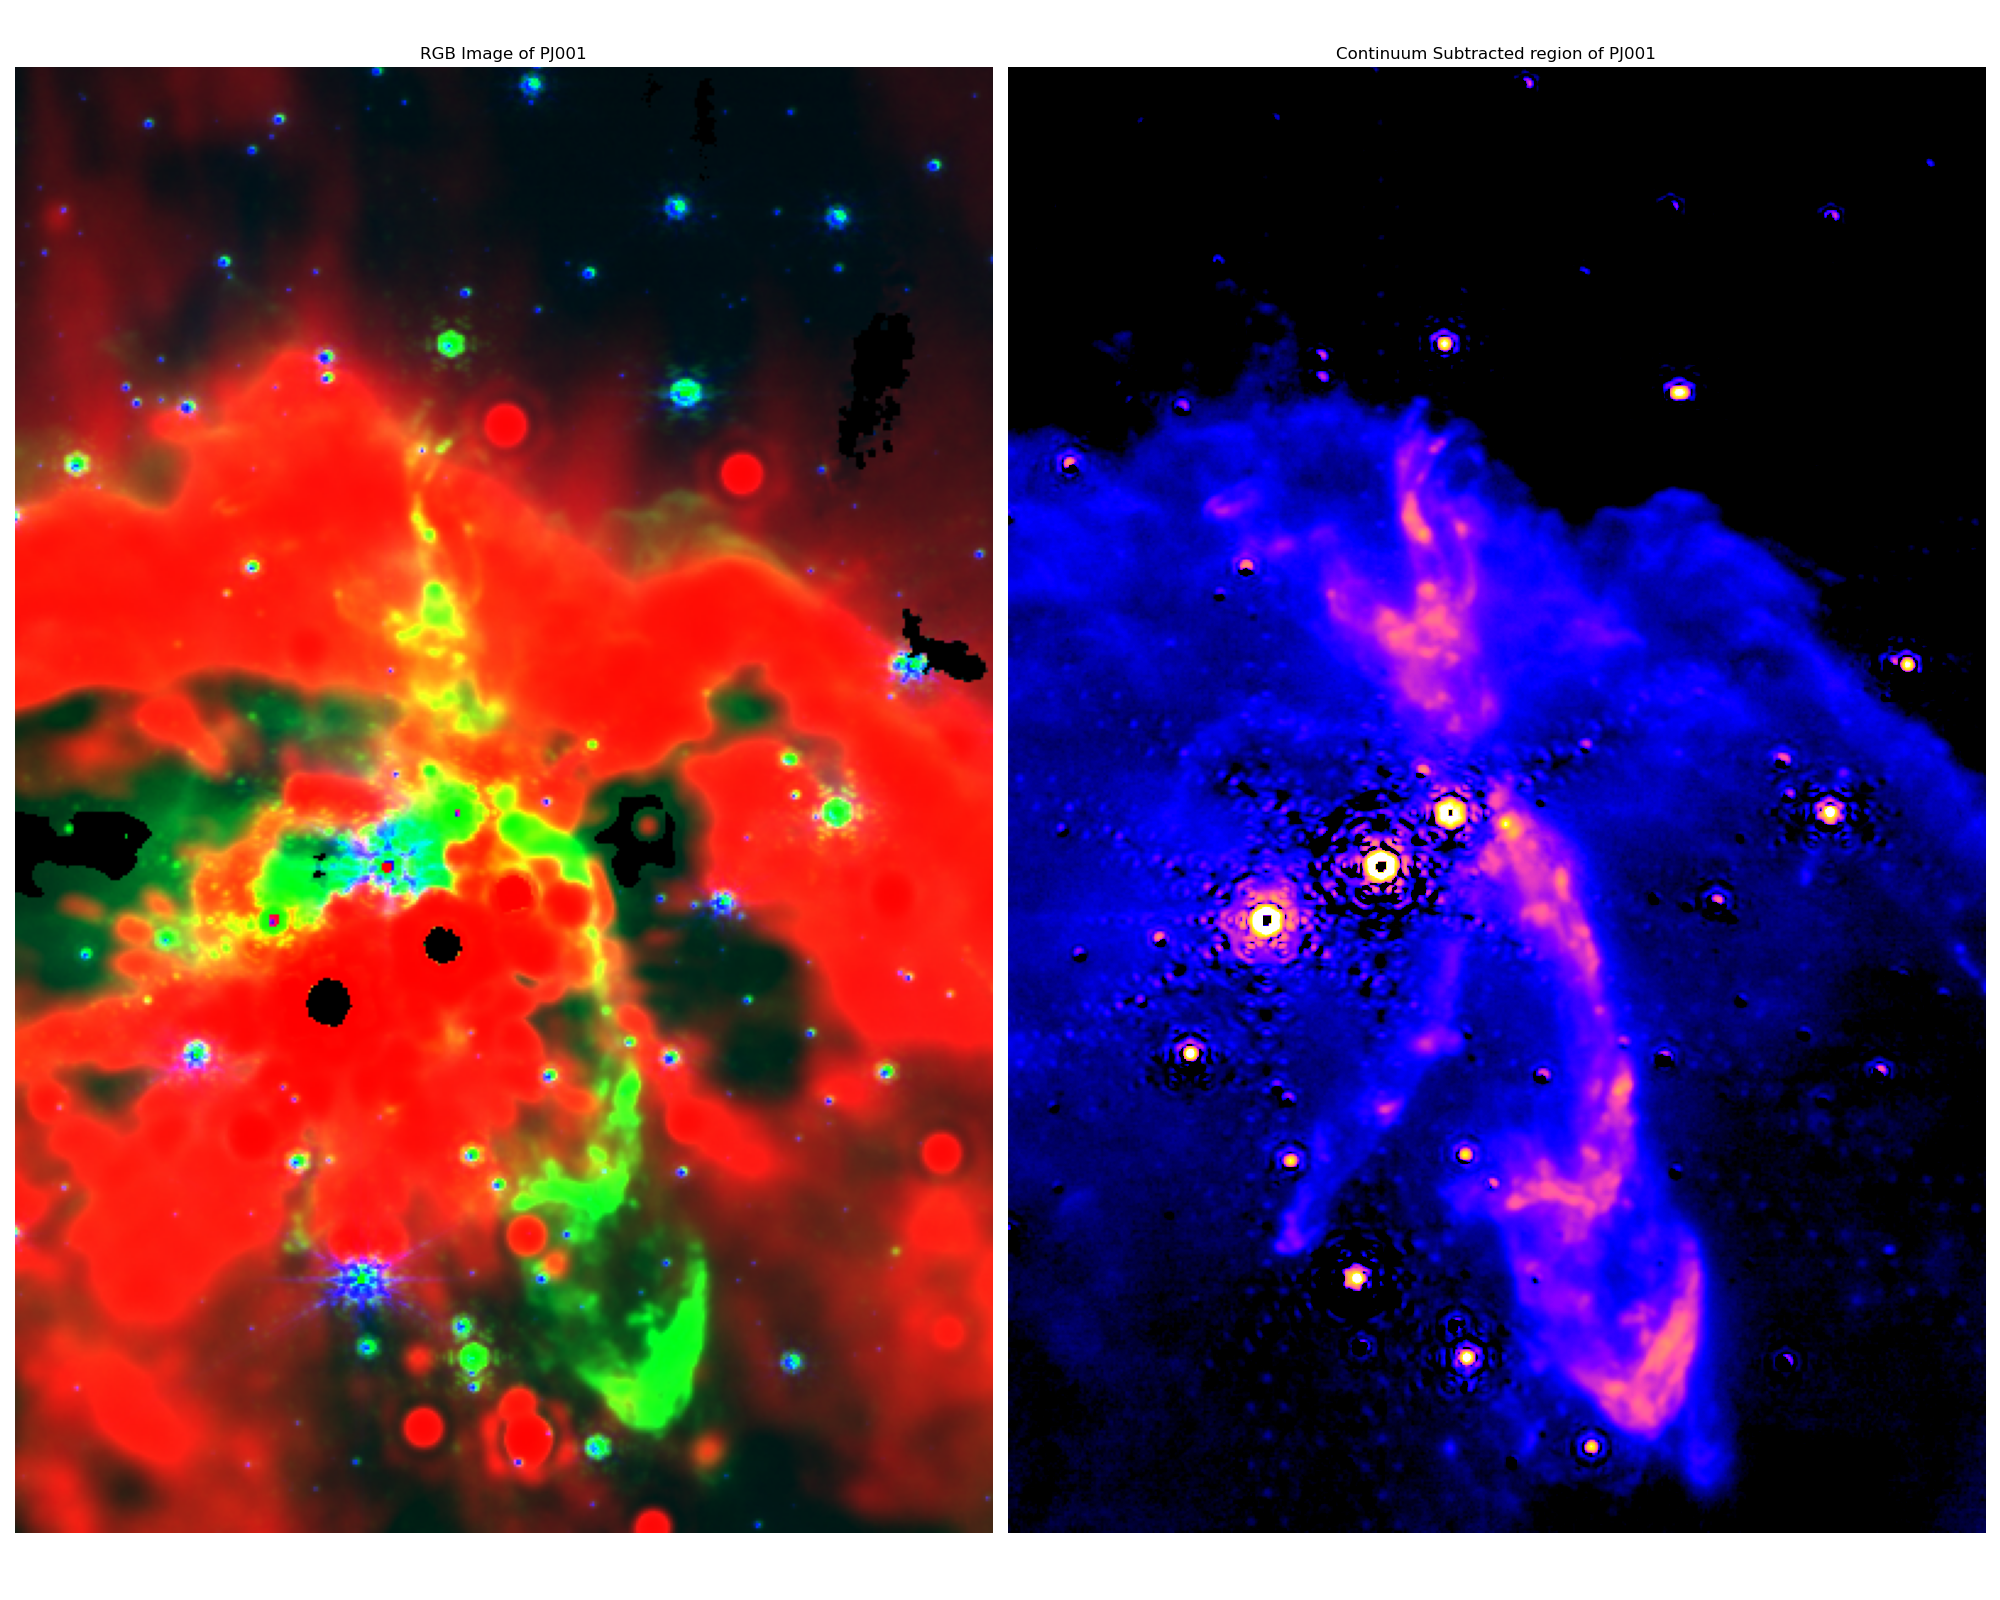

In [38]:
# PLOT
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(20, 16)

axs[0].imshow(rgb, origin='lower')
axs[0].set_title(f'RGB Image of {focus}')
axs[0].axis('off')

axs[1].imshow(c_crop, origin='lower', norm = simple_norm(c_crop, stretch='log', invalid=0, min_cut=0, max_cut=900), cmap='gnuplot2')
axs[1].set_title(f'Continuum Subtracted region of {focus}')
axs[1].axis('off')

plt.tight_layout()
plt.show()